In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model

import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pylab as plt
from keras.layers import Dense, Dropout, Input, Concatenate

import os
import numpy as np

In [2]:
data_dir=r"dataset/valid"
skin=[]
for file in os.listdir(data_dir):
    skin+=[file]
print(skin)
print(len(skin))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
7


In [3]:
train_datagen= ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.4,
                height_shift_range=0.4,
                shear_range=0.2,
                zoom_range=0.2,
                fill_mode="nearest",
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1./255,
                preprocessing_function=None)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
                    'dataset/train',
                    target_size=(224, 224),
                    color_mode='rgb',
                    shuffle=True,
                    batch_size=16)

validation_generator = test_datagen.flow_from_directory(
                    'dataset/valid',
                    target_size=(224, 224),
                    color_mode='rgb',
                    batch_size=16)

Found 8512 images belonging to 7 classes.
Found 1503 images belonging to 7 classes.


In [4]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [5]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
pre_trained_model = InceptionV3(input_shape=(224, 224, 3),
include_top=False, weights="imagenet")
pre_trained_model.summary()
for layer in pre_trained_model.layers:
 layer.trainable=False

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [10]:
model=Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(layers.Dense(7,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 34,912,039
Trainable params: 13,109,255
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
from keras.optimizers import Adam,SGD,Nadam,RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                    decay_steps=1000,
                                    decay_rate=0.6)
def schedule(epoch,lr):
    if epoch <=2 :
        return lr
    elif epoch > 2 and epoch <=4 :
        return lr/2
    elif epoch > 4 and epoch < 7 :
        return lr/3
    else:
        return lr/4

optimizer1 = Adam(learning_rate = 0.014)
optimizer2 = SGD(learning_rate = lr_schedule)
optimizer3 = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.4)
optimizer4 = Nadam(learning_rate=0.002)

cb1 = EarlyStopping(monitor='val_loss', patience = 10)
cb2 = tf.keras.callbacks.LearningRateScheduler(schedule,verbose=1)

model_checkpoint_callback = ModelCheckpoint(
                                    filepath='inceptionV3.h5',
                                    save_weights_only=True,
                                    monitor='val_acc',
                                    mode='max',
                                    save_best_only=True)

In [12]:
model.compile(optimizer=optimizer2,
              loss='categorical_crossentropy',
              metrics =['accuracy',precision,recall,sensitivity,specificity])

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
history=model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, callbacks =[model_checkpoint_callback])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8372\2018710333.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=train_gen,


Epoch 1/30
532/532 [==============================] - 772s 1s/step - loss: 1.2525 - accuracy: 0.6564 - precision: 0.7820 - recall: 0.5150 - sensitivity_at_specificity: 0.9805 - specificity_at_sensitivity: 0.9980 - val_loss: 0.8861 - val_accuracy: 0.6687 - val_precision: 0.8243 - val_recall: 0.6116 - val_sensitivity_at_specificity: 0.9960 - val_specificity_at_sensitivity: 0.9999
Epoch 2/30
532/532 [==============================] - 730s 1s/step - loss: 0.9744 - accuracy: 0.6699 - precision: 0.8189 - recall: 0.5445 - sensitivity_at_specificity: 0.9925 - specificity_at_sensitivity: 0.9994 - val_loss: 0.8770 - val_accuracy: 0.6774 - val_precision: 0.8656 - val_recall: 0.5625 - val_sensitivity_at_specificity: 0.9993 - val_specificity_at_sensitivity: 0.9999
Epoch 3/30
532/532 [==============================] - 750s 1s/step - loss: 0.9417 - accuracy: 0.6699 - precision: 0.8274 - recall: 0.5586 - sensitivity_at_specificity: 0.9925 - specificity_at_sensitivity: 0.9997 - val_loss: 0.8248 - val_a

Epoch 14/30
532/532 [==============================] - 749s 1s/step - loss: 0.8463 - accuracy: 0.6965 - precision: 0.8477 - recall: 0.5794 - sensitivity_at_specificity: 0.9952 - specificity_at_sensitivity: 0.9997 - val_loss: 0.7788 - val_accuracy: 0.7137 - val_precision: 0.8507 - val_recall: 0.6089 - val_sensitivity_at_specificity: 0.9980 - val_specificity_at_sensitivity: 1.0000
Epoch 15/30
532/532 [==============================] - 746s 1s/step - loss: 0.8503 - accuracy: 0.6957 - precision: 0.8474 - recall: 0.5806 - sensitivity_at_specificity: 0.9947 - specificity_at_sensitivity: 0.9997 - val_loss: 0.7756 - val_accuracy: 0.7124 - val_precision: 0.8607 - val_recall: 0.6062 - val_sensitivity_at_specificity: 0.9980 - val_specificity_at_sensitivity: 1.0000
Epoch 16/30
532/532 [==============================] - 750s 1s/step - loss: 0.8510 - accuracy: 0.6934 - precision: 0.8467 - recall: 0.5777 - sensitivity_at_specificity: 0.9960 - specificity_at_sensitivity: 0.9998 - val_loss: 0.7761 - va

Epoch 27/30
532/532 [==============================] - 751s 1s/step - loss: 0.8394 - accuracy: 0.6961 - precision: 0.8471 - recall: 0.5799 - sensitivity_at_specificity: 0.9951 - specificity_at_sensitivity: 0.9997 - val_loss: 0.7769 - val_accuracy: 0.7110 - val_precision: 0.8493 - val_recall: 0.6095 - val_sensitivity_at_specificity: 0.9980 - val_specificity_at_sensitivity: 1.0000
Epoch 28/30
532/532 [==============================] - 744s 1s/step - loss: 0.8377 - accuracy: 0.6950 - precision: 0.8514 - recall: 0.5797 - sensitivity_at_specificity: 0.9965 - specificity_at_sensitivity: 0.9997 - val_loss: 0.7800 - val_accuracy: 0.7097 - val_precision: 0.8495 - val_recall: 0.6069 - val_sensitivity_at_specificity: 0.9980 - val_specificity_at_sensitivity: 1.0000
Epoch 29/30
532/532 [==============================] - 763s 1s/step - loss: 0.8362 - accuracy: 0.6940 - precision: 0.8488 - recall: 0.5806 - sensitivity_at_specificity: 0.9954 - specificity_at_sensitivity: 0.9997 - val_loss: 0.7769 - va

In [13]:
model.save("NEW models/InceptionV3.h5")

In [14]:
model.evaluate(validation_generator, verbose=1, steps=STEP_SIZE_VALID)

93/93 [==============================] - 91s 972ms/step - loss: 0.7718 - accuracy: 0.7124 - precision: 0.8529 - recall: 0.6116 - sensitivity_at_specificity: 0.9973 - specificity_at_sensitivity: 1.0000


[0.7718124985694885,
 0.7123655676841736,
 0.8528584837913513,
 0.6115591526031494,
 0.9973118305206299,
 1.0]

In [15]:
filenames = validation_generator.filenames 
nb_samples = len(filenames)
model_predict = model.predict(validation_generator,steps = nb_samples, verbose=2)

1503/1503 - 96s - 96s/epoch - 64ms/step


Confusion matrix, without normalization
[[  0   2   4   0   1  42   0]
 [  0   2  10   0   1  64   0]
 [  0   6  21   0   2 136   0]
 [  0   0   1   0   0  16   0]
 [  0   2  12   0   3 150   0]
 [  0  13 128   0   5 860   0]
 [  0   1   2   0   0  19   0]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

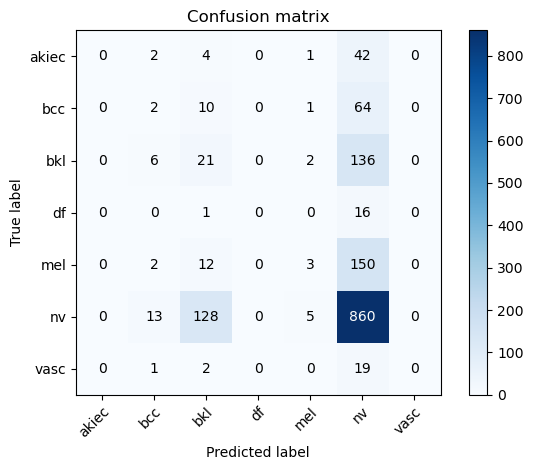

In [16]:
y_true = validation_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['akiec','bcc','bkl','df','mel','nv','vasc'],
                      title='Confusion matrix')

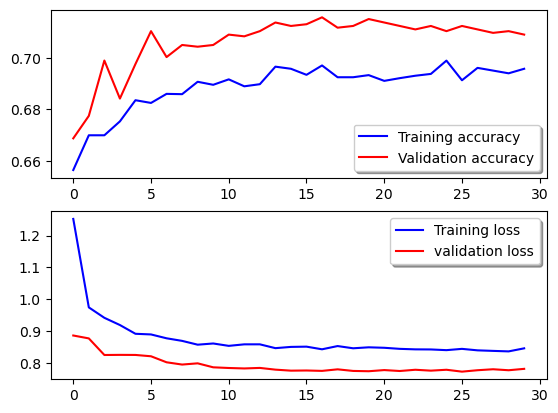

In [17]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)